## NIPS Topic Model using Expectation Maximization (EM)

The UCI Machine Learning dataset repository hosts several datasets recording word counts for documents [here](https://archive.ics.uci.edu/ml/datasets/Bag+of+Words). Here we will use the NIPS dataset.

It provides (a) a table of word counts per document and (b) a vocabulary list for this dataset at the link.

We implement the multinomial mixture of topics model using our own EM clustering code.

### Cluster to 30 topics, using a simple mixture of multinomial topic model.

In [25]:
# import libs
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

from math import log
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

# read data
D = 1500
W = 12419
NNZ = 746316
J = 30 # number of topics/ clusters
CONVERGENCE_THRESHOLD = 0.0001
SMOOTHING_CONST = 0.0002

data = np.loadtxt(r'data/docword.nips.txt', dtype=int, delimiter=' ',skiprows=3)

We use CSR matrix for optimal performance as the data matrix is sparse

In [26]:
# store data as numpy matrix
# we subtract by 1 to make data zero-indexed
row = data[:, 0] - 1
col = data[:, 1] - 1
values = data[:, 2]

x = csr_matrix((values, (row, col)), shape=(D, W))

# CSR matrix to numpy
X = x.toarray()

Here we start with uniform distribution of p and pi.
Rather a better way might be to use results from k-means clustering (a variant of EM) to get rough clusters.

**Caution**: pi should not have a zero-element. An infinitesimal smoothing must be applied in such situations, else no documents may be assigned to the corresponding topic.

In [27]:
# p corresponds to probability of word in a topic
p = np.ones((J, W))
p = 1.0/W * p

# pi corresponds to probability that document belongs to topic
pi = np.ones(J)
pi = 1.0/J * pi

Using k-means for better initial values of p's and pi's

In [28]:
est = KMeans(n_clusters=30)
est.fit(X)
topic_id = est.labels_

In [29]:
# get initial p from k-means
for j in range(J):
    topic_j_docs = X[topic_id == j, :]
    topic_j_word_dist = np.sum(topic_j_docs, 0)
    p[j,] = topic_j_word_dist / np.sum(topic_j_word_dist)

In [30]:
# get initial pi from k-means
pi = np.array([np.sum(topic_id == i) for i in range(J)])
pi = pi / float(D)

# check that there are no zero values in pi's
0 not in pi

True

In [31]:
def logsumexp(X):
    """
    log sum exp trick for approximation to avoid underflow/ overflow
    :param X: data matrix
    :return: log sum exp applied to each row of input matrix X
    """
    x_max = X.max(1)
    return x_max + np.log(np.exp(X - x_max[:, None]).sum(1))

We keep a list of expectation value *q* so we can visualize change in q as we iterate through *EM*

*Note: There are several ways to check for convergences of EM. We use difference between expectations in consecutive iterations as measure of convergence* 

In [32]:
# EM
iter_count = 1
list_of_q = [sys.maxsize]

while True:
    # log likelihood
    ll = x.dot(np.log(p).T) + np.log(pi)
    
    # calculate w_i,j matrix
    w = np.exp((ll.T - logsumexp(ll)).T)

    ### E-Step ###
    
    q = np.sum(ll * w)
    print(q)
    list_of_q.append(q)
    
    # check for convergence
    if abs(q - list_of_q[-2]) < CONVERGENCE_THRESHOLD:
        break
    
    ### M-Step ###
    
    # update p
    for j in range(J):
        numerator = np.sum(np.multiply(X.T, w[:,j]).T, 0)
        denominator = np.sum(np.sum(X, 1) * w[:,j])
        p[j,] = (numerator + SMOOTHING_CONST)/(denominator + (SMOOTHING_CONST * W))
        
    # update pi
    pi = np.sum(w, 0)/ D
    
    # print("finished iteration", iter_count)
    iter_count += 1

print("EM finished after " + str(iter_count) + " iterations")

/Users/Zubin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/Users/Zubin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply


nan
-14294849.6778
-14288011.2853
-14287228.4194
-14286467.0459
-14286233.6827
-14286233.7585
-14286134.5632
-14285444.0908
-14284726.6578
-14284576.4408
-14284576.4408
EM finished after 12 iterations


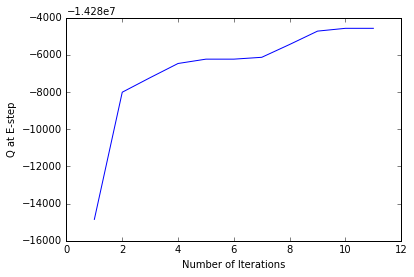

In [33]:
%matplotlib inline
plt.plot(list_of_q[1:])
plt.xlabel("Number of Iterations")
plt.ylabel("Q at E-step")
plt.show()

Above graph shows convergence of Q as we progress through iterations of EM algorithm

### Graph showing, for each topic, the probability with which the topic is selected.


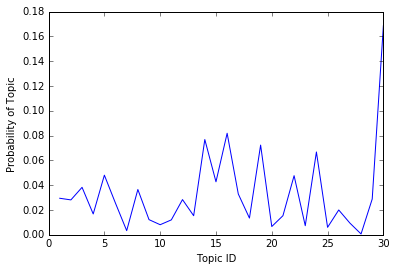

In [34]:
%matplotlib inline
plt.plot([i for i in range(1,31)], pi)
plt.xlabel("Topic ID")
plt.ylabel("Probability of Topic")
plt.show()

Note that the y-axis/ probabilities in above graph do not range from 0 to 1

### Table showing, for each topic, the 10 words with the highest probability for that topic.

In [35]:
with open("data/vocab.nips.txt") as f:
    word_dict = f.readlines()

num_words = 10

for j in range(J):
    ind = np.argpartition(p[j,], -num_words)[-num_words:]
    ind = ind[np.argsort(p[j, ind])][::-1] # sorted indices
    print("Topic " + str(j) + ":", [word_dict[i].replace('\n','') for i in ind])

Topic 0: ['neuron', 'network', 'model', 'input', 'neural', 'system', 'function', 'current', 'pattern', 'cell']
Topic 1: ['function', 'network', 'input', 'weight', 'neural', 'number', 'unit', 'result', 'threshold', 'bound']
Topic 2: ['circuit', 'chip', 'current', 'output', 'analog', 'input', 'system', 'voltage', 'neural', 'network']
Topic 3: ['model', 'control', 'learning', 'movement', 'system', 'dynamic', 'forward', 'trajectory', 'controller', 'motor']
Topic 4: ['network', 'training', 'weight', 'set', 'neural', 'error', 'unit', 'learning', 'input', 'output']
Topic 5: ['network', 'neural', 'input', 'system', 'output', 'problem', 'set', 'function', 'learning', 'training']
Topic 6: ['network', 'model', 'error', 'data', 'set', 'cross', 'neural', 'unit', 'validation', 'variables']
Topic 7: ['learning', 'action', 'function', 'policy', 'algorithm', 'problem', 'optimal', 'system', 'states', 'reinforcement']
Topic 8: ['data', 'cluster', 'clustering', 'algorithm', 'point', 'model', 'set', 'dista

Above we can see the most frequent ten words in each topic